In [33]:
import os
os.chdir(os.path.expanduser("~/phd/phd_nbeats_with_feature_vector"))

import neurokit2 as nk
import numpy as np
import sklearn as sk
from challenge import *
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import math
import ecg_plot
import pywt
from scipy.signal import find_peaks
import functools
import operator
from sklearn import tree
import seaborn as sns
import scipy 
import time

def clean_labels(header):
    logger.debug(f"Clean label for header file: {header}")
    classes_from_header = get_labels(header)
    
    logger.debug(f"Classes found in header: {classes_from_header}")
    if '733534002' in classes_from_header:
        classes_from_header[classes_from_header.index('733534002')] = '164909002'
        classes_from_header = list(set(classes_from_header))
    if '713427006' in classes_from_header:
        classes_from_header[classes_from_header.index('713427006')] = '59118001'
        classes_from_header = list(set(classes_from_header))
    if '63593006' in classes_from_header:
        classes_from_header[classes_from_header.index('63593006')] = '284470004'
        classes_from_header = list(set(classes_from_header))
    if '427172004' in classes_from_header:
        classes_from_header[classes_from_header.index('427172004')] = '17338001'
        classes_from_header = list(set(classes_from_header))

    return classes_from_header

data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/ptb/g1"
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

xls = pd.ExcelFile('label_mappings.xlsx')
df = pd.read_excel(xls, 'PTB')

df_labels_to_class_list=df[['SNOMED code','Diagnosis in the dataset']].set_index('SNOMED code').apply(lambda row: {row.name: row.values.tolist()[0]}, axis=1).tolist()
labels_to_class= reduce(lambda a, b: a|b, df_labels_to_class_list)
labels_to_class

{164889003: 'atrial fibrillation',
 164890007: 'atrial flutter',
 6374002: 'bundle branch block',
 204384007: 'congenital incomplete av block',
 53741008: 'coronary artery disease',
 698247007: 'dysrhythmia',
 84114007: 'hf heart failure',
 266249003: 'hypertrophy',
 164871004: 'lateral infarction',
 233910005: 'lone atrial fibrillation',
 164865005: 'myocardial infarction',
 282825002: 'paf paroxysmal atrial fibrillation',
 314208002: 'rapid atrial fibrillation',
 426783006: 'sinus rhythm',
 368009: 'valvular heart disease',
 164896001: 'ventricular fibrillation',
 164895002: 'vt ventricular tachycardia',
 74390002: 'wpw'}

In [2]:

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)

def build_dict_for_labels(labels, header_files, recording_files):
    result = {}
    for i in range(len(header_files)):
        header = load_header(header_files[i])
        current_labels= clean_labels(header)
        if current_labels[0] not in result:
            result[current_labels[0]] = [(header_files[i], recording_files[i])]
        else:
            result[current_labels[0]].append((header_files[i], recording_files[i]))
    return result

files_per_label = build_dict_for_labels(labels_to_class.keys(), header_files, recording_files)        
    


Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locat

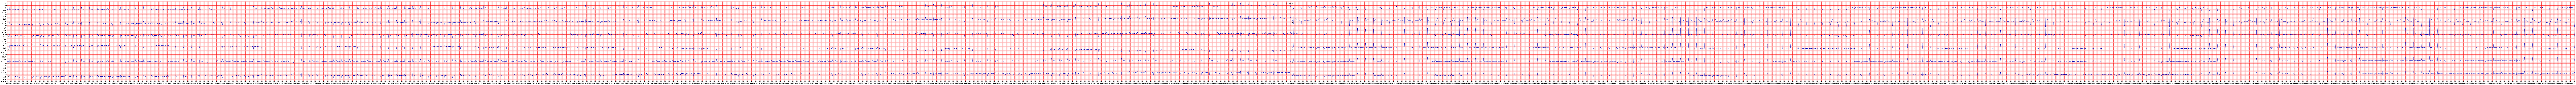

Locator attempting to generate 5761 ticks ([0.0, ..., 230.4]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: 

In [3]:
def plot_ecg_example_for_classes(list_classes, files_per_label):
    for c in list_classes:
        header_file, recording_file=files_per_label[c][0]
        # print(f"Finished loading: {num_recordings} files")

        header = load_header(header_file)
        recording = np.array(load_recording(recording_file), dtype=np.float32)
        
        ecg_plot.plot(recording / 1000, sample_rate = 1000, title = c)
        ecg_plot.show()

plot_ecg_example_for_classes(files_per_label.keys(), files_per_label)

(12, 2666)
2500


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


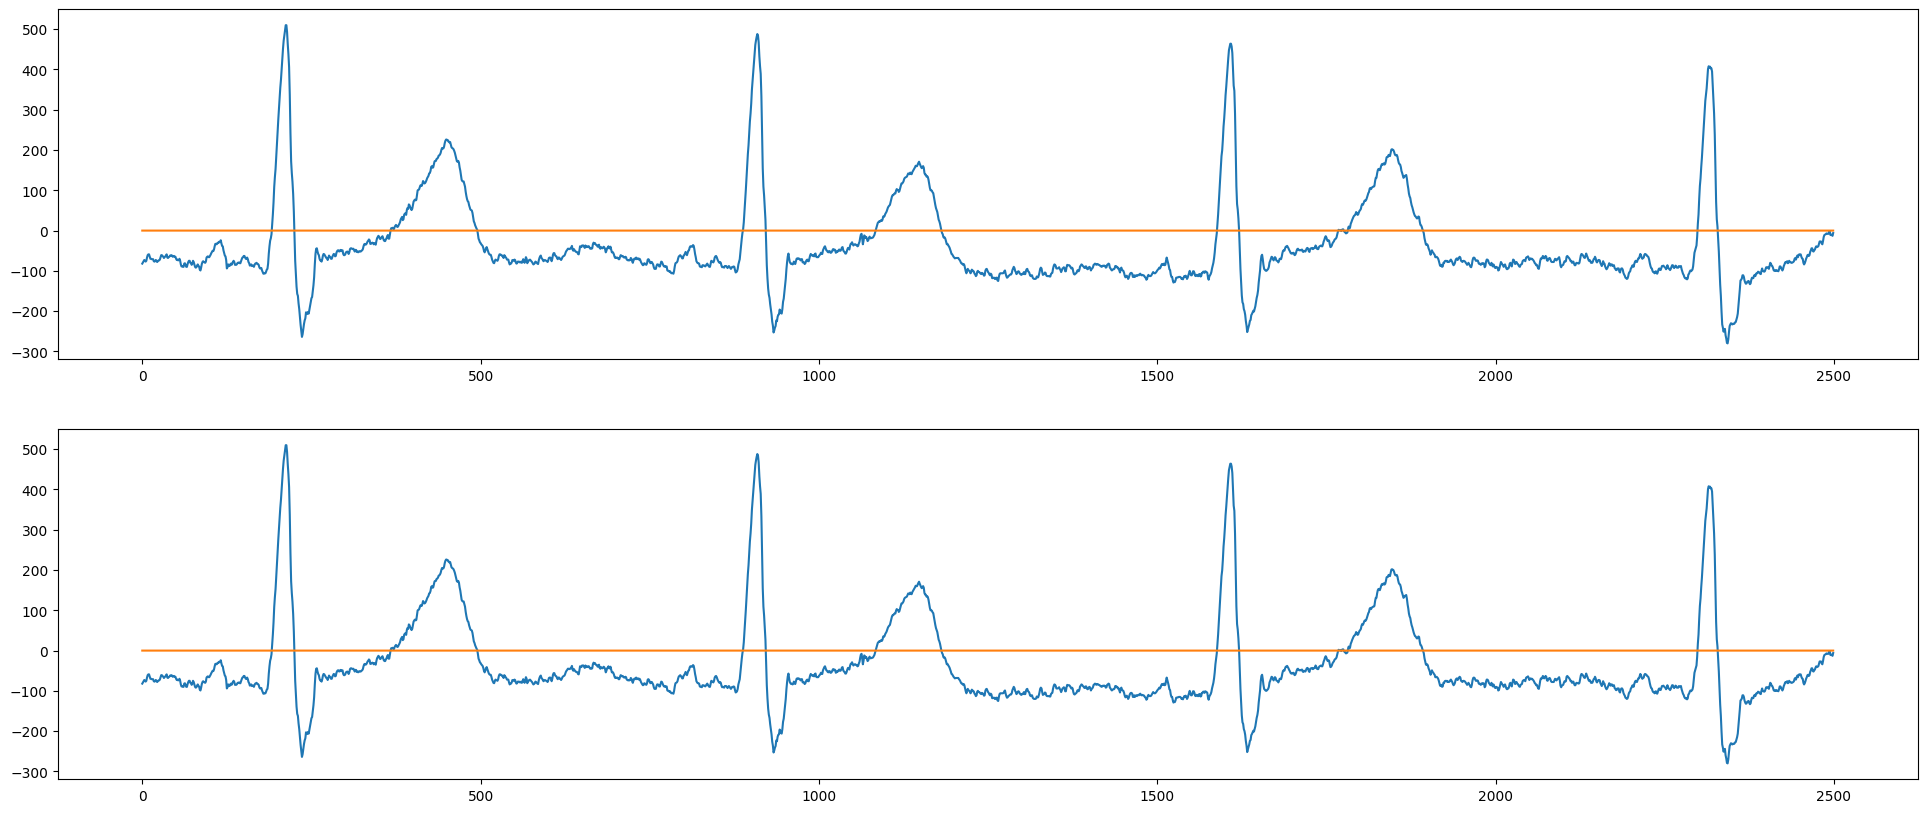

In [69]:
def baseline_wandering_removal(signal, wavelet, level):
    N = len(signal[0])
    coeffs = pywt.wavedec(data=signal, wavelet=wavelet, level=level)
    print(np.hstack(coeffs).shape)
    print(N)

    reconstructed_approximates = [pywt.upcoef('a', coeffs[0][i], wavelet, level=level)[:N] for i in range(len(signal))]
    result = signal - reconstructed_approximates
    return result, coeffs

header_file, recording_file = files_per_label['164865005'][0]
header= load_header(header_file)
recording = np.array(load_recording(recording_file), dtype=np.float32)
(exemplar_singal_with_bw_removed, _) = baseline_wandering_removal(recording[:, :2500], 'sym10', 9)
figure, axis = plt.subplots(2, 1)
figure.set_size_inches(24,10)

axis[0].plot(range(len(exemplar_singal_with_bw_removed[0])), exemplar_singal_with_bw_removed[4][:2500])
axis[0].plot(range(len(exemplar_singal_with_bw_removed[0])), np.zeros(len(exemplar_singal_with_bw_removed[0])))
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0])), recording[4][:2500])
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0])), np.zeros(len(exemplar_singal_with_bw_removed[0])))


0.0032520294189453125


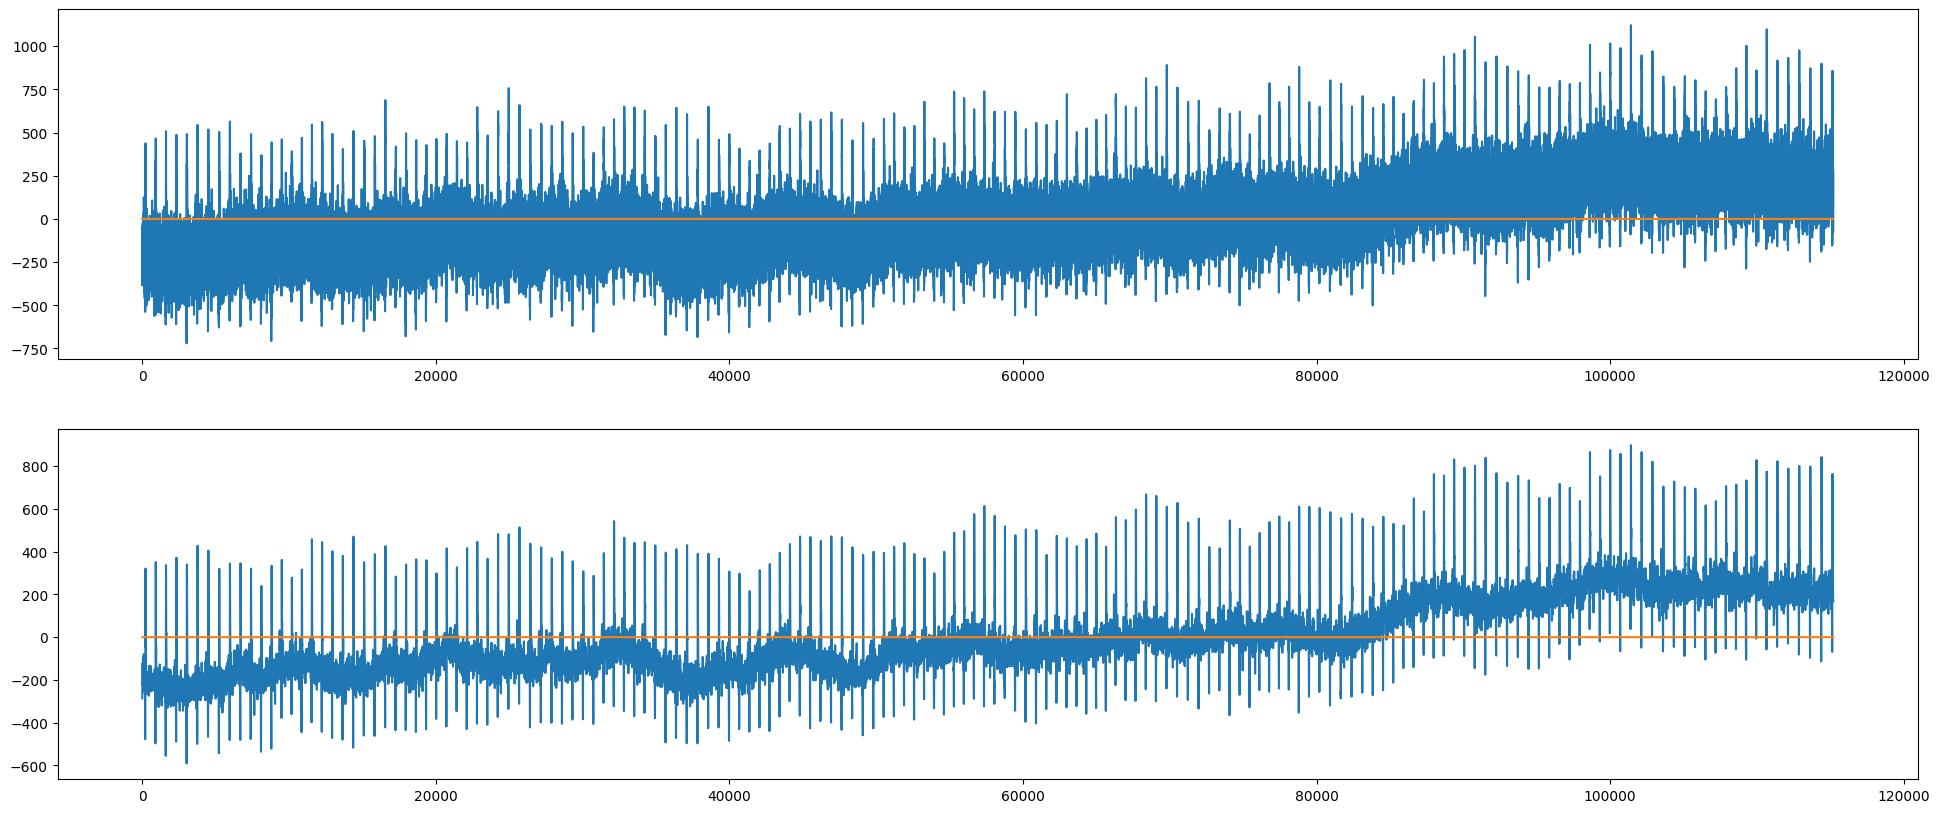

In [127]:
def sigma_est_dwt(detail_coeffs, distribution='Gaussian'):
    """Calculate the robust median estimator of the noise standard deviation.

    Parameters
    ----------
    detail_coeffs : ndarray
        The detail coefficients corresponding to the discrete wavelet
        transform of an image.
    distribution : str
        The underlying noise distribution.

    Returns
    -------
    sigma : float
        The estimated noise standard deviation (see section 4.2 of [1]_).

    References
    ----------
    .. [1] D. L. Donoho and I. M. Johnstone. "Ideal spatial adaptation
       by wavelet shrinkage." Biometrika 81.3 (1994): 425-455.
       :DOI:`10.1093/biomet/81.3.425`
    """
    # Consider regions with detail coefficients exactly zero to be masked out
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    if distribution.lower() == 'gaussian':
        # 75th quantile of the underlying, symmetric noise distribution
        denom = scipy.stats.norm.ppf(0.75)
        sigma = np.median(np.abs(detail_coeffs)) / denom
    else:
        raise ValueError("Only Gaussian noise estimation is currently " "supported")
    return sigma



def _bayes_thresh(details, var):
    """BayesShrink threshold for a zero-mean details coeff array."""
    # Equivalent to:  dvar = np.var(details) for 0-mean details array
    dvar = np.mean(details * details)
    eps = np.finfo(details.dtype).eps
    thresh = var / np.sqrt(max(dvar - var, eps))
    return thresh



def wavelet_threshold(
    signal, coeffs,
    wavelet,
    threshold=None,
    sigma=None,
    mode='soft',
    wavelet_levels=None,
):
   
    dcoeffs = coeffs[1:]
    original_extent = tuple(slice(s) for s in signal.shape)


    if sigma is None:
        # Estimate the noise via the method in [2]_
        detail_coeffs = dcoeffs[-1]#['d' * signal.ndim]
        sigma = sigma_est_dwt(detail_coeffs, distribution='Gaussian')

    if threshold is None:
        var = sigma**2
        threshold = [
             _bayes_thresh(level, var) for level in dcoeffs
        ]

    if np.isscalar(threshold):
        # A single threshold for all coefficient arrays
        denoised_detail = [
            {
                key: pywt.threshold(level[key], value=threshold, mode=mode)
                for key in level
            }
            for level in dcoeffs
        ]
    else:
        # Dict of unique threshold coefficients for each detail coeff. array
        denoised_detail = [
            pywt.threshold(level, value=thresh, mode=mode) for thresh, level in zip(threshold, dcoeffs)
        ]
    denoised_coeffs = [coeffs[0]] + denoised_detail
    out = pywt.waverec(denoised_coeffs, wavelet)[original_extent]
    out = out.astype(signal.dtype)
    return out

noise = np.random.normal(0,100,len(recording[11]))


signal = recording[11] + noise
wavelet='db6'
#wavelet='sym10'

s = time.time()
coeffs = pywt.wavedec(data=signal, wavelet=wavelet, level=3)
smoothed = wavelet_threshold(signal, coeffs, wavelet)
print(time.time() - s)

figure, axis = plt.subplots(2, 1)
figure.set_size_inches(24,10)
axis[0].plot(range(len(signal)), signal)
axis[0].plot(range(len(signal)), np.zeros(len(signal)))
axis[1].plot(range(len(smoothed)), smoothed)
axis[1].plot(range(len(smoothed)), np.zeros(len(smoothed)))
plt.show()


In [124]:
rpeaks = nk.ecg_findpeaks(smoothed, sampling_rate=500)
print(rpeaks)
rpeaks['ECG_R_Peaks'] = [ 223,  919, 1618, 2328]
print((np.mean(np.diff(rpeaks['ECG_R_Peaks'])) / 500 ) * 60)
print(nk.ecg_rate(rpeaks, sampling_rate=500))
s, i = nk.ecg_delineate(smoothed, rpeaks, sampling_rate=500)
s

rpeaks_avg = [[ 223,  919, 1618, 2328], [ 230,  926, 1625, np.nan], [ 225,  921, 1620, 2330]]


rpeaks_avg = np.array(rpeaks_avg)
peaks = np.mean(rpeaks_avg[:, ~np.any(np.isnan(rpeaks_avg), axis=0)], axis=0)
        
peaks


{'ECG_R_Peaks': array([   223,    480,    919,   1617,   2328,   3041,   3300,   3767,
         4183,   4505,   5244,   5974,   6198,   6696,   7409,   7832,
         8113,   8464,   8815,   9505,   9869,  10191,  10873,  11558,
        12253,  12954,  13374,  13664,  13871,  14391,  14591,  14809,
        15116,  15561,  15847,  16167,  16566,  17273,  17526,  17973,
        18664,  19358,  19783,  20046,  20383,  20743,  20942,  21438,
        22128,  22825,  23117,  23528,  24239,  24623,  24963,  25222,
        25695,  26007,  26439,  27176,  27902,  28303,  28616,  28920,
        29096,  29327,  29607,  30041,  30751,  31446,  32142,  32551,
        32840,  33303,  33535,  33999,  34239,  34950,  35319,  35665,
        36387,  37113,  37847,  38575,  38830,  39288,  39997,  40295,
        40689,  40959,  41382,  42070,  42752,  42991,  43433,  44125,
        44380,  44815,  45519,  46230,  46447,  46943,  47664,  48384,
        49111,  49825,  50224,  50529,  50847,  51225,  51919

array([ 226.,  922., 1621.])

In [140]:
leads_idxs = {'I': 0, 'II': 1, 'III':2, 'aVR': 3, 'aVL':4, 'aVF':5, 'V1':6, 'V2':7, 'V3':8, 'V4':9, 'V5':10, 'V6':11}
sampling_rate = 500
signals = {}
infos = {}
rpeaks_avg = []
rates = {}
wavelet="db6"
for lead_name, idx in leads_idxs.items(): 
  
    coeffs = pywt.wavedec(data=recording[idx], wavelet=wavelet, level=3)
    recording[idx] = wavelet_threshold(recording[idx], coeffs, wavelet)
    
    rpeaks = nk.ecg_findpeaks(recording[idx], sampling_rate, method="pantompkins1985") 
    signal, info =nk.ecg_delineate(recording[idx], rpeaks=rpeaks, sampling_rate=sampling_rate, method='dwt')

    signals[lead_name] = signal
    infos[lead_name] = info
    rpeaks_avg.append(rpeaks['ECG_R_Peaks'])

    rates[lead_name] = nk.ecg_rate(rpeaks, sampling_rate=500)

lxs= [len(x) for x in rpeaks_avg]
print(lxs)
min_length = min(lxs)

print(min_length)
print(len(rpeaks_avg))
print(len(rpeaks_avg[0]))

rpeaks_equal = [rpeaks_avg[i][ :min_length] for i in range(len(rpeaks_avg))]
lxs= [len(x) for x in rpeaks_equal]
print(lxs)

rpeaks_avg = np.array(rpeaks_equal)

peaks = np.mean(rpeaks_avg[:, ~np.any(np.isnan(rpeaks_avg), axis=0)], axis=0, dtype=int)

peaks

[168, 167, 167, 168, 167, 168, 167, 168, 169, 168, 166, 168]
166
12
168
[166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]


array([   154,    507,    682,    870,   1151,   1631,   2113,   2736,
         3461,   4183,   4925,   5660,   6388,   7112,   7817,   8518,
         9212,   9904,  10584,  11274,  11952,  12661,  13364,  14085,
        14802,  15546,  16266,  16973,  17678,  18375,  19068,  19755,
        20453,  21149,  21832,  22486,  23182,  23888,  24607,  25331,
        26072,  26810,  27549,  28263,  28974,  29699,  30401,  31104,
        31797,  32493,  33190,  33889,  34597,  35313,  36032,  36755,
        37486,  38215,  38939,  39647,  40347,  41046,  41732,  42413,
        43099,  43787,  44473,  45168,  45878,  46586,  47306,  48031,
        48750,  49470,  50184,  50883,  51576,  52272,  52953,  53634,
        54307,  54989,  55663,  56345,  57026,  57724,  58426,  59134,
        59831,  60499,  61208,  61905,  62599,  63279,  63949,  64623,
        65288,  65951,  66624,  67300,  67989,  68684,  69387,  70107,
        70830,  71561,  72288,  72999,  73698,  74384,  75060,  75742,
      

In [144]:
peaks = np.array([[ 223,  919, 1618, 2328], [ 230,  926, 1625, 2335], [ 225,  921, 1620, 2330]])
print((np.mean(np.diff(peaks)) / 500 ) * 60)

info.keys()

84.2


dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

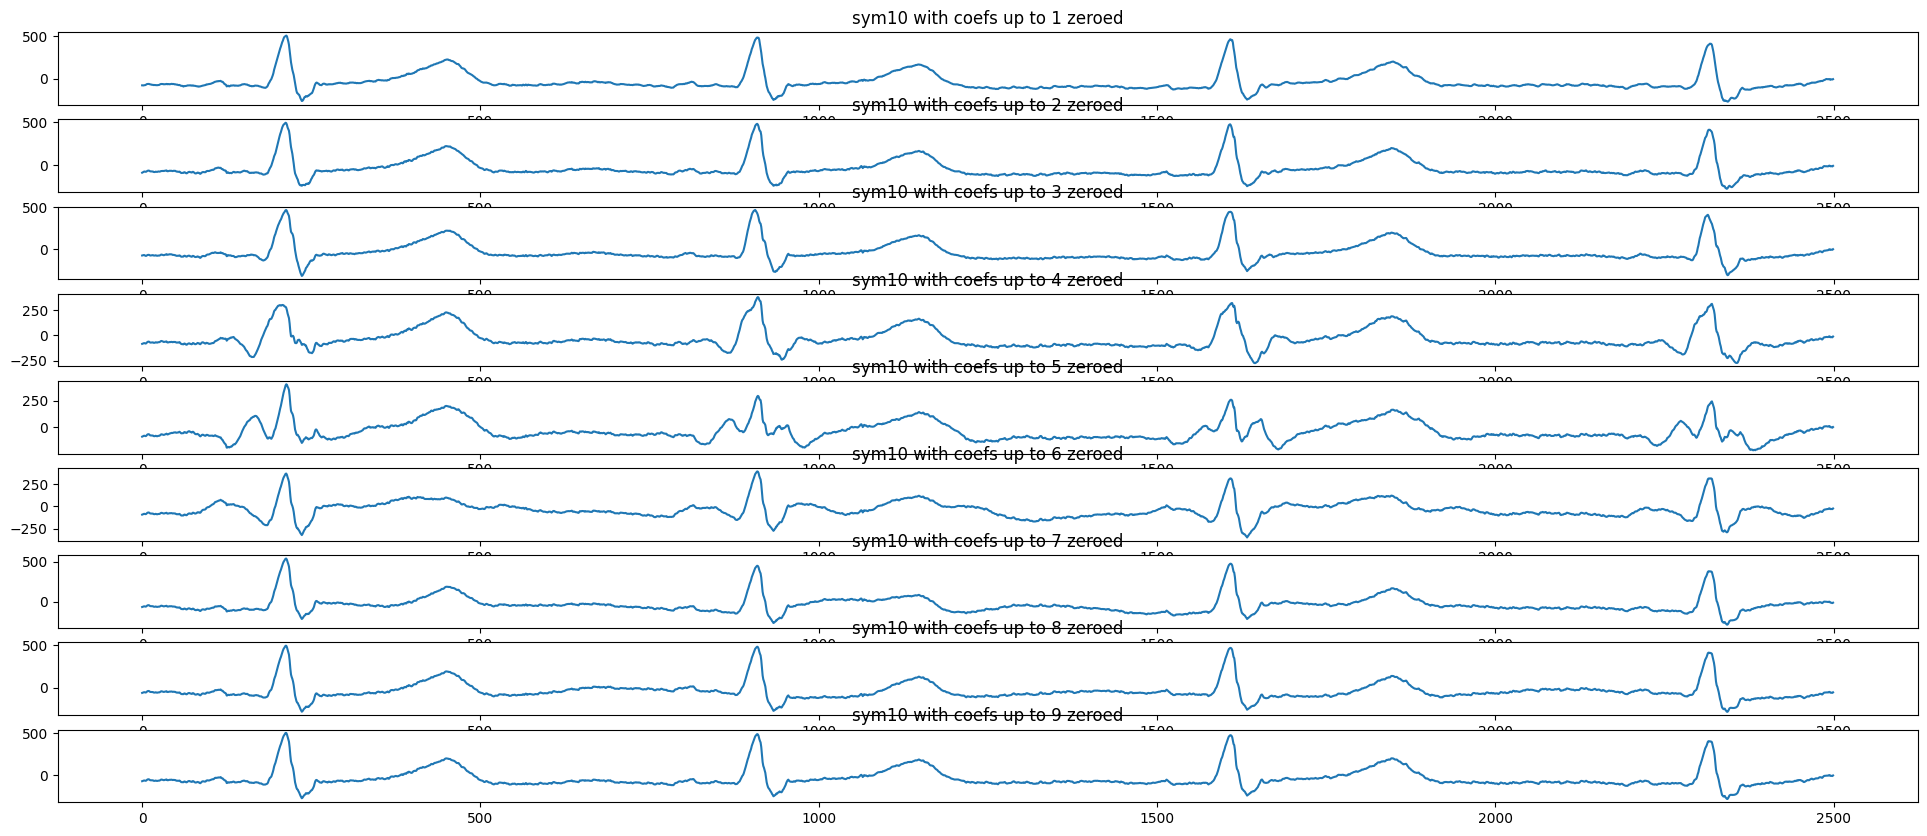

In [6]:
def show_difference_in_denoising(signal, wavelet, level):
    N = len(signal)
    figure, axis = plt.subplots(level, 1)
    figure.set_size_inches(24,10)
    for l in range(1, level+1):
        DWTcoeffs = pywt.wavedec(recording[4], wavelet)

        for sub_l in range(l):    
            DWTcoeffs[-1*(l+1)] = np.zeros_like(DWTcoeffs[-1*(l+1)])
    
        filtered_data_dwt=pywt.waverec(DWTcoeffs,wavelet,mode='symmetric',axis=-1)[:N]
        axis[l-1].plot(range(len(filtered_data_dwt)), filtered_data_dwt)
        axis[l-1].title.set_text(f"{wavelet} with coefs up to {l} zeroed")

    plt.show()

show_difference_in_denoising(recording[4][:2500], 'sym10', 9)

In [76]:
def n_baseline_wandering_removal(signal, wavelet, level):
    N = len(signal[0])
    coeffs = pywt.wavedec2(data=signal, wavelet=wavelet, level=level)
    print(len(coeffs[0]))
    coeffs[-1] = tuple([np.zeros_like(v) for v in coeffs[-1]])

    print(N)

    reconstructed_approximates = pywt.waverec2( coeffs, wavelet)[:N]
    result = signal - reconstructed_approximates
    return result, coeffs


def n_wavelet_threshold(
    image, coeffs,
    wavelet,
    method=None,
    threshold=None,
    sigma=None,
    mode='soft',
    wavelet_levels=None,
):

    original_extent = tuple(slice(s) for s in image.shape)

    # Determine the number of wavelet decomposition levels
    if wavelet_levels is None:
        # Determine the maximum number of possible levels for image
        wavelet_levels = pywt.dwtn_max_level(image.shape, wavelet)

        # Skip coarsest wavelet scales (see Notes in docstring).
        wavelet_levels = max(wavelet_levels - 3, 1)

    # coeffs = pywt.wavedecn(image, wavelet=wavelet, level=wavelet_levels)
    # Detail coefficients at each decomposition level
    dcoeffs = coeffs[1:]

    if sigma is None:
        # Estimate the noise via the method in [2]_
        detail_coeffs = dcoeffs[-1]['d' * image.ndim]
        sigma = _sigma_est_dwt(detail_coeffs, distribution='Gaussian')

    if method is not None and threshold is not None:
        warn(
            f'Thresholding method {method} selected. The '
            f'user-specified threshold will be ignored.'
        )

    if threshold is None:
        var = sigma**2

        threshold = [
            {key: _bayes_thresh(level[key], var) for key in level}
            for level in dcoeffs
        ]
      
    if np.isscalar(threshold):
        # A single threshold for all coefficient arrays
        denoised_detail = [
            {
                key: pywt.threshold(level[key], value=threshold, mode=mode)
                for key in level
            }
            for level in dcoeffs
        ]
    else:
        # Dict of unique threshold coefficients for each detail coeff. array
        denoised_detail = [
            {
                key: pywt.threshold(level[key], value=thresh[key], mode=mode)
                for key in level
            }
            for thresh, level in zip(threshold, dcoeffs)
        ]
    denoised_coeffs = [coeffs[0]] + denoised_detail
    out = pywt.waverecn(denoised_coeffs, wavelet)[original_extent]
    out = out.astype(image.dtype)
    return out



(12, 115364)
115200


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (12, 57600).

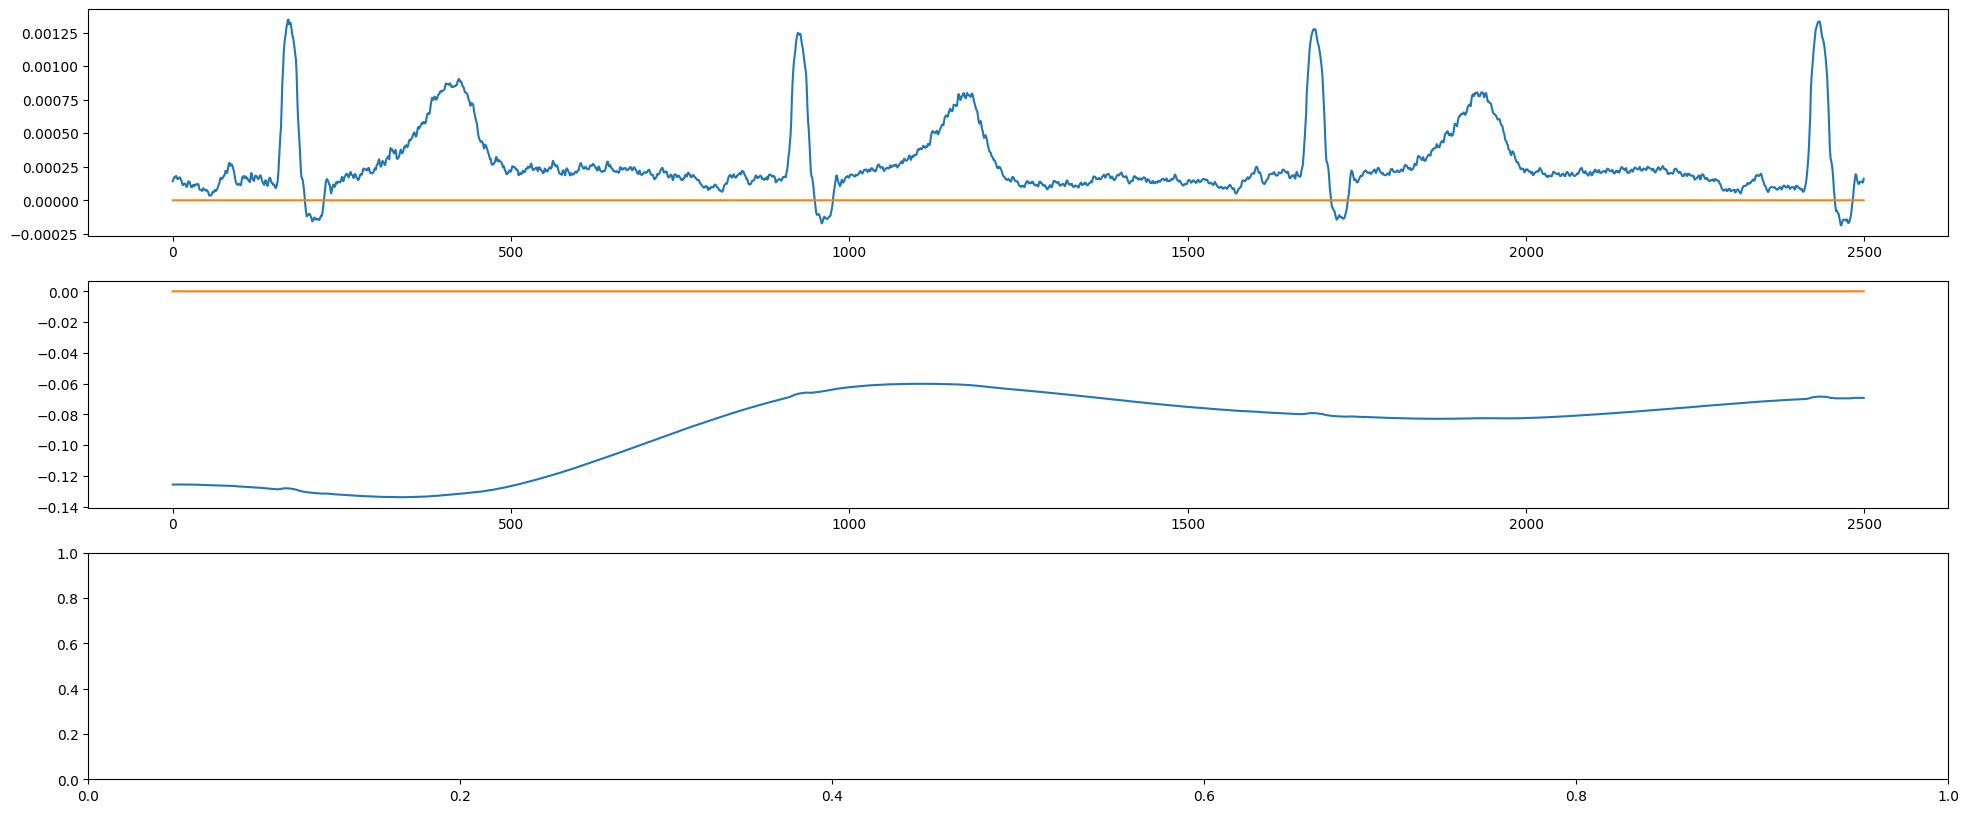

In [78]:
signal = recording[:][-2500:]
# signal /= np.max(np.abs(signal),axis=0)

(exemplar_singal_with_bw_removed, coeffs) = n_baseline_wandering_removal(signal, 'sym10', 9)
# smoothed = n_wavelet_threshold(exemplar_singal_with_bw_removed, coeffs, 'db6', sigma=0.2)


# (exemplar_singal_with_bw_removed, coeffs) = baseline_wandering_removal(signal, 'db6', 6)
# print(f"Coeffs len: {len(coeffs)}")
# smoothed = n_wavelet_threshold(exemplar_singal_with_bw_removed, coeffs, 'db6', sigma=0.2)


(cA, cD) = pywt.dwt(smoothed, 'haar')
figure, axis = plt.subplots(3, 1)
figure.set_size_inches(24,10)
axis[0].plot(range(len(recording[4][-2500:])), recording[4][-2500:])
axis[0].plot(range(len(recording[4][-2500:])), np.zeros(len(recording[4][-2500:])))
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0][-2500:])), exemplar_singal_with_bw_removed[4][-2500:])
axis[1].plot(range(len(exemplar_singal_with_bw_removed[0][-2500:])), np.zeros(len(exemplar_singal_with_bw_removed[4][-2500:])))
axis[2].bar(range(len(cD)), cD)
plt.show()

In [154]:
peaks, _ = scipy.signal.find_peaks(smoothed, distance=30, height=0.6)
negative_peaks, _ = scipy.signal.find_peaks(-smoothed, distance=30, height=0.1)

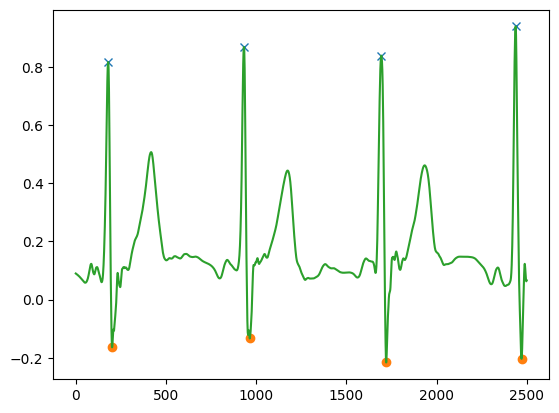

In [156]:
plt.plot(peaks, smoothed[peaks], "x")
plt.plot(negative_peaks, smoothed[negative_peaks], "o")
plt.plot(smoothed)

In [180]:
def process(header_file, recording_file):
    header = load_header(header_file)
    recording = np.array(load_recording(recording_file), dtype=np.float32)
    
    signal_raw = recording[7][-2500:]
    signal = signal_raw / np.max(np.abs(signal_raw),axis=0)
    N = len(signal)
    
    (exemplar_singal_with_bw_removed, coeffs) = baseline_wandering_removal(signal, 'db6', 6)
    smoothed = wavelet_threshold(exemplar_singal_with_bw_removed, coeffs, 'db6', sigma=0.1)

    peaks, _ = scipy.signal.find_peaks(smoothed, distance=30, height=0)
    negative_peaks, _ = scipy.signal.find_peaks(-smoothed, distance=10, height=0.3)
    
    
    (cA, cD) = pywt.dwt(smoothed, 'haar')
    figure, axis = plt.subplots(3, 1)
    figure.set_size_inches(24,10)
    axis[1].plot(peaks, smoothed[peaks], "x")
    axis[1].plot(negative_peaks, smoothed[negative_peaks], "o")
    axis[0].plot(range(N), signal_raw)
    axis[0].plot(range(N), np.zeros(N))
    axis[1].plot(range(N), smoothed)
    axis[1].plot(range(N), np.zeros(N))
    axis[2].bar(range(len(cD)), cD)
    plt.show()

1
[0.01667101719061947, 0.02070690487940058, 0.09621174594980347, 28.963094253083238, 28.963094253083238, 28.963094253083238]


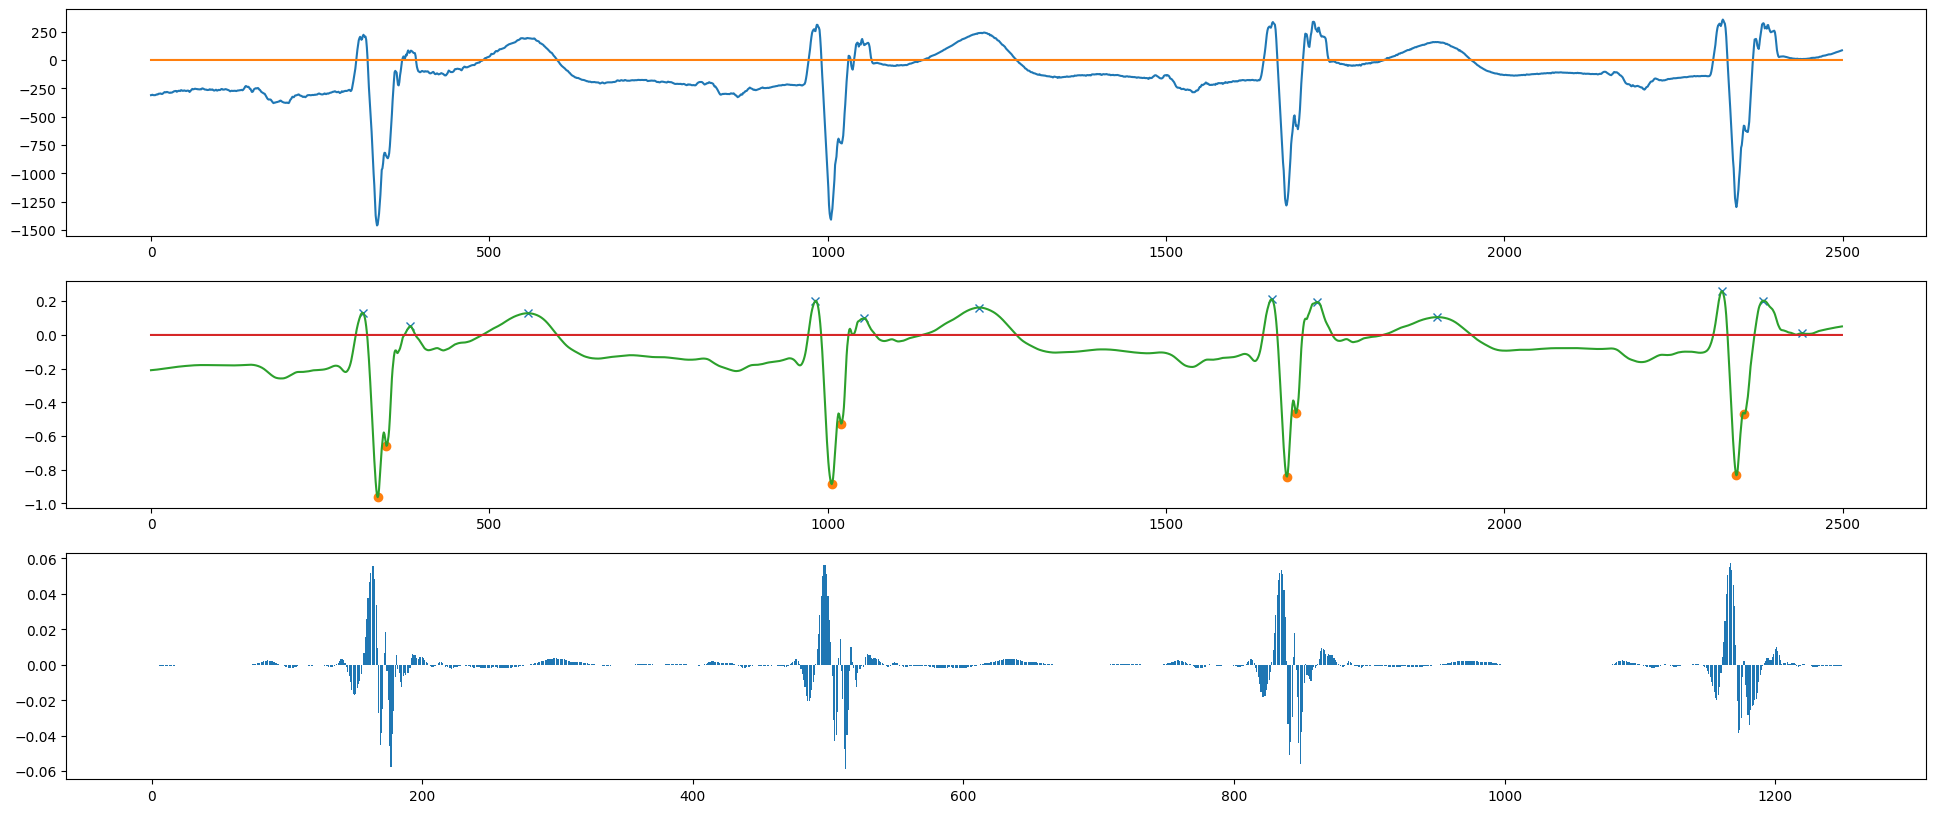

In [181]:
process(*files_per_label['6374002'][0])

In [ ]:
valid_positive_peaks = [peaks[i] for i in range(len(peaks) - 1) if peaks[i+1] - peaks[i] <100]
valid_negative_peaks = [negative_peaks[i] for i in range(len(negative_peaks) - 1) if negative_peaks[i+1] - negative_peaks[i] <100]